In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
from sklearn.model_selection import train_test_split , GridSearchCV 
import seaborn as ss
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix ,accuracy_score
from sklearn.metrics import *
from sklearn.datasets import make_classification

In [4]:
df = pd.read_csv('/content/Copy of models.csv')
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [25]:
#Non_relevant feature
non_rel_col = []
for i in df.columns:
  if int(len(df[i].unique()) == df.shape[0]):
    non_rel_col.append(i)
    print(non_rel_col)


['Loan_ID']


In [0]:
#Saving the Loan ID feature in another dataframe
df_loan_id = df['Loan_ID']
#Dropping Loan ID from Featureset
df=df.drop(columns='Loan_ID')

In [30]:
#Columns after droping non_relevant columns
df.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [5]:
# Target class distribution
df['Loan_Status'].value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

In [38]:
# **continuous features**
continuous_col= df._get_numeric_data().columns
continuous_col = []
for i in df.columns:
  if(len(df[i].unique())) > int(df.shape[0]/25):
     continuous_col.append(i)
print (continuous_col)

['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']


In [39]:
# **Categorical features**
categorical_col = list(set(df.columns) - set(continuous_col))
categorical_col

['Self_Employed',
 'Gender',
 'Married',
 'Loan_Amount_Term',
 'Education',
 'Property_Area',
 'Loan_Status',
 'Credit_History',
 'Dependents']

**Outliers Handiling**

In [41]:
continuous_col

['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']

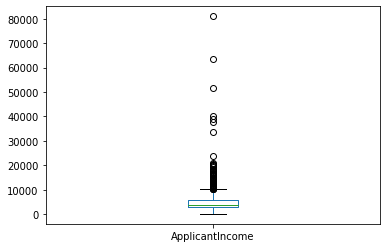

In [44]:
#Outliers representation 
df['ApplicantIncome'].plot.box()

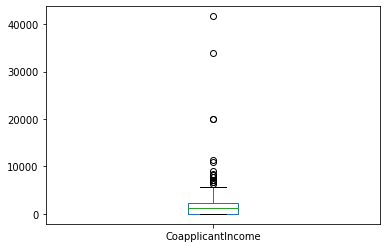

In [45]:
df['CoapplicantIncome'].plot.box()

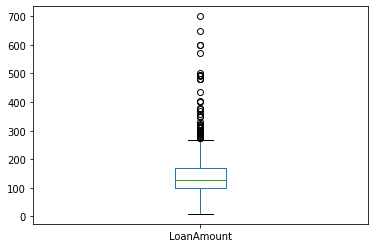

In [46]:
df['LoanAmount'].plot.box()

In [49]:
df[['ApplicantIncome','CoapplicantIncome','LoanAmount']].describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount
count,614.000000,614.000000,592.000000
mean,5403.459283,1621.245798,146.413851
std,6109.041673,2926.248369,85.586932
min,150.000000,0.000000,9.000000
25%,2877.500000,0.000000,100.000000
50%,3812.500000,1188.500000,128.000000
75%,5795.000000,2297.250000,168.000000
max,81000.000000,41667.000000,700.000000


*Z score method* {just for innovative sake, may be not a best way}

In [312]:
# dealing outliers with only ApplicantIncome , CoapplicantIncome columns 
# LoanAmount feature will not bother with their non-extreame value of outliers
z = stats.zscore(df[['ApplicantIncome', 'CoapplicantIncome']])
z = np.abs(z)       #only positve values
z                   #z-score of ApplicantIncome 

array([[0.2896802 , 0.84480702],
       [0.08517747, 0.05138345],
       [0.55389762, 0.84480702],
       ...,
       [0.94790185, 0.70217723],
       [0.80311085, 0.84480702],
       [0.08517747, 0.84480702]])

In [80]:
threshold = 3   # setting threshold value
print(np.where(z > 3))      #Uppar array showing rows and lower array showing columns
                            # z[581][1] is max 

(array([  9, 126, 155, 171, 177, 183, 185, 333, 402, 409, 417, 443, 581,
       600]), array([1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1]))


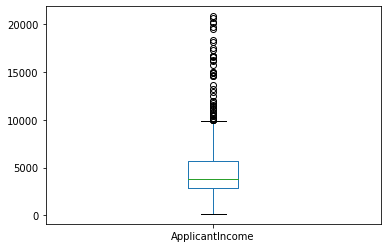

In [96]:
df= df[(z < 3).all(axis=1)]
#Outliers representation after apply Zscore 
df['ApplicantIncome'].plot.box()

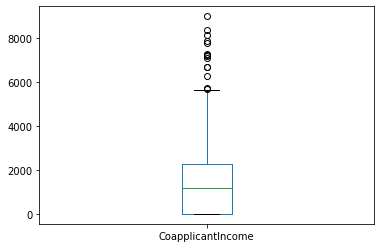

In [97]:
df['CoapplicantIncome'].plot.box()

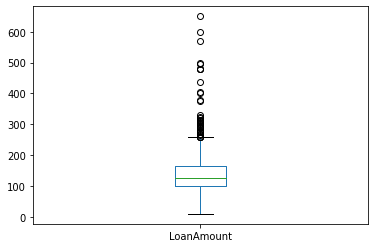

In [98]:
df['LoanAmount'].plot.box()

In this method i set threshod value = 3,
Either we also can change it to 2 or 4 (as your convenience)

**Handling missing values**

In [100]:
#Null values in dataset
df.isnull().sum()

Gender               11
Married               3
Dependents           15
Education             0
Self_Employed        30
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       49
Property_Area         0
Loan_Status           0
dtype: int64

In [104]:
#Sparsity of Records
#Checking Sparse rows , if >= 33.3% of columns of a record is not populated then remove the record itself
# Found no record Sparsely populated
rows_missing = df.isnull().sum(axis=1).reset_index() 
rows_missing.columns = ['row','mis_cnt']
rows_missing[(rows_missing['mis_cnt'] > int(df.shape[1]/3))]

,row,mis_cnt


Replace null values with mode value(of that column) in categorical columns 

In [106]:
#Populate the Missing values in Categorical columns with Mode value
df.mode().iloc[0]      #Model value for every feature

Gender                    Male
Married                    Yes
Dependents                   0
Education             Graduate
Self_Employed               No
ApplicantIncome           2500
CoapplicantIncome            0
LoanAmount                 120
Loan_Amount_Term           360
Credit_History               1
Property_Area        Semiurban
Loan_Status                  Y
Name: 0, dtype: object

In [109]:
#Categorical Columns with missing values
df[categorical_col].isnull().sum()

Self_Employed       30
Gender              11
Married              3
Loan_Amount_Term    14
Education            0
Property_Area        0
Loan_Status          0
Credit_History      49
Dependents          15
dtype: int64

In [0]:
# Fill with mode values in categorical Columns
for i in categorical_col:
  if ( df[i].isnull().sum() > 0):
    df[i] = df[i].fillna(df[i].mode().iloc[0])

In [313]:
#After filling mode values
df[categorical_col].isnull().sum()

Self_Employed       0
Gender              0
Married             0
Loan_Amount_Term    0
Education           0
Property_Area       0
Loan_Status         0
Credit_History      0
Dependents          0
dtype: int64

Replace null values with mean value(of that column) in continuous columns 

In [120]:
df[continuous_col].mean()

ApplicantIncome      4870.668333
CoapplicantIncome    1421.538200
LoanAmount            141.866782
dtype: float64

In [314]:
# Nan values in continuous columns
df[continuous_col].isnull().sum()

ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
dtype: int64

In [130]:
# Only LoanAmount columns contains null values, no need of using for loop
df['LoanAmount']=df['LoanAmount'].fillna(df['LoanAmount'].mean())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [132]:
#null values after filling with mean value
df[continuous_col].isnull().sum()

ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
dtype: int64

**------Use Label Encoder as encoding technique on features , predict using below algorithms------**

**Using Logistic Regression - Perform the parameter tuning and list** **your best performance metrics on -**

**Precision ,Recall & F1 Score ,AUROC**

In [137]:
#Label ecoding on categorical features
df_le = df.copy()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,141.866782,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,2900,0.0,71.000000,360.0,1.0,Rural,Y
610,Male,Yes,3+,Graduate,No,4106,0.0,40.000000,180.0,1.0,Rural,Y
611,Male,Yes,1,Graduate,No,8072,240.0,253.000000,360.0,1.0,Urban,Y
612,Male,Yes,2,Graduate,No,7583,0.0,187.000000,360.0,1.0,Urban,Y


In [0]:
#Label ecoding on categorical features
le = LabelEncoder()   #Initiated LabelEncoder

In [141]:
df_target_le = pd.DataFrame(le.fit_transform(df_le['Loan_Status']))
df_target_le.columns = (['Loan_Status'])
df_target_le.head()

,Loan_Status
0,1
1,0
2,1
3,1
4,1


In [142]:
for i in categorical_col:
  if (str(i) == 'Loan_Status'):
    continue
  else:
    df_le['enc_'+str(i)] = le.fit_transform(df[i])
df_le

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,enc_Self_Employed,enc_Gender,enc_Married,enc_Loan_Amount_Term,enc_Education,enc_Property_Area,enc_Credit_History,enc_Dependents
0,Male,No,0,Graduate,No,5849,0.0,141.866782,360.0,1.0,Urban,Y,0,1,0,8,0,2,1,0
1,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N,0,1,1,8,0,0,1,1
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y,1,1,1,8,0,2,1,0
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y,0,1,1,8,1,2,1,0
4,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y,0,1,0,8,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,2900,0.0,71.000000,360.0,1.0,Rural,Y,0,0,0,8,0,0,1,0
610,Male,Yes,3+,Graduate,No,4106,0.0,40.000000,180.0,1.0,Rural,Y,0,1,1,5,0,0,1,3
611,Male,Yes,1,Graduate,No,8072,240.0,253.000000,360.0,1.0,Urban,Y,0,1,1,8,0,2,1,1
612,Male,Yes,2,Graduate,No,7583,0.0,187.000000,360.0,1.0,Urban,Y,0,1,1,8,0,2,1,2


In [0]:
df_le = df_le.drop(columns=categorical_col)

In [147]:
df_le     #Label ecoded features

,ApplicantIncome,CoapplicantIncome,LoanAmount,enc_Self_Employed,enc_Gender,enc_Married,enc_Loan_Amount_Term,enc_Education,enc_Property_Area,enc_Credit_History,enc_Dependents
0,5849,0.0,141.866782,0,1,0,8,0,2,1,0
1,4583,1508.0,128.000000,0,1,1,8,0,0,1,1
2,3000,0.0,66.000000,1,1,1,8,0,2,1,0
3,2583,2358.0,120.000000,0,1,1,8,1,2,1,0
4,6000,0.0,141.000000,0,1,0,8,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...
609,2900,0.0,71.000000,0,0,0,8,0,0,1,0
610,4106,0.0,40.000000,0,1,1,5,0,0,1,3
611,8072,240.0,253.000000,0,1,1,8,0,2,1,1
612,7583,0.0,187.000000,0,1,1,8,0,2,1,2


In [186]:
df_target_le   #Label encoded target feature

,Loan_Status
0,1
1,0
2,1
3,1
4,1
...,...
595,1
596,1
597,1
598,1


In [0]:
#Splitting data
X_train, X_test, Y_train, Y_test = train_test_split(df_le, df_target_le, test_size=0.20, random_state=78 , stratify=df_target_le)

In [153]:
#test data size - 20% of dataset
print("Train Feature set:\t"+str(len(X_train)))
print("Train Label Feature set:\t"+str(len(Y_train)))
print("Test Feature set:\t"+str(len(X_test)))
print("Test label set:\t"+str(len(Y_test)))

Train Feature set:	480
Train Label Feature set:	480
Test Feature set:	120
Test label set:	120


In [155]:
#distribution of training and test data
print("For Training Data :")
print(Y_train['Loan_Status'].value_counts())
lbl_1,lbl_0 = Y_train['Loan_Status'].value_counts()
print("Label 1 class %age: "+str((lbl_1*100)/Y_train['Loan_Status'].count()))
print("Label 0 class %age: "+str((lbl_0*100)/Y_train['Loan_Status'].count()))
print("\nFor Test Set :")
print(Y_test['Loan_Status'].value_counts())
lbl_1,lbl_0 = Y_test['Loan_Status'].value_counts()
print("Label 1 class %age: "+str((lbl_1*100)/Y_test['Loan_Status'].count()))
print("Label 0 class %age: "+str((lbl_0*100)/Y_test['Loan_Status'].count()))

For Training Data :
1    332
0    148
Name: Loan_Status, dtype: int64
Label 1 class %age: 69.16666666666667
Label 0 class %age: 30.833333333333332

For Test Set :
1    83
0    37
Name: Loan_Status, dtype: int64
Label 1 class %age: 69.16666666666667
Label 0 class %age: 30.833333333333332


In [183]:
#Training of data 
clf_dt = LogisticRegression(random_state=78)
clf_dt.fit(X_train, Y_train)
print(clf_dt)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=78, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [316]:
#Testing
y_pred = clf_dt.predict(X_test)
y_pred

array([0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [187]:
confusion_matrix(Y_test, y_pred)

array([[11, 26],
       [ 2, 81]])

In [168]:
print("Accuracy of Dtree Model:")
print(accuracy_score(Y_test, y_pred))
print("Precision of DTree Model:")
print (precision_score(Y_test, y_pred))
print ("Recall of DTree Model:" )
print( recall_score(Y_test, y_pred))
print ("F1 Score of DTree Model:")
print (f1_score(Y_test, y_pred))

Accuracy of Dtree Model:
0.7666666666666667
Precision of DTree Model:
0.7570093457943925
Recall of DTree Model:
0.9759036144578314
F1 Score of DTree Model:
0.8526315789473685


In [169]:
roc_auc_score(Y_test,y_pred)

0.6366004558775643

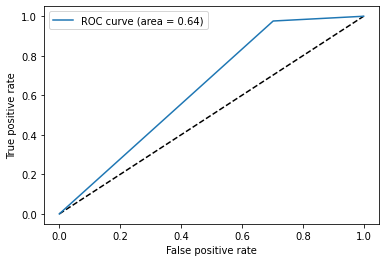

In [170]:
fpr, tpr, thresholds = roc_curve(Y_test,y_pred)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)'% roc_auc_score(Y_test,y_pred))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')

**Using RandomForest Classifier - Perform the parameter tuning and list your best performance metrics on**

**Precision ,Recall & F1 Score ,AUROC**

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(df_le, df_target_le, test_size=0.25, random_state=40, stratify=df_target_le)

In [0]:
clf = RandomForestClassifier(random_state=40)

In [206]:
clf.fit(X_train,Y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=40, verbose=0,
                       warm_start=False)

In [209]:
y_pred = clf.predict(X_test)
y_pred

array([1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1])

In [210]:
confusion_matrix(Y_test, y_pred)

array([[22, 24],
       [ 5, 99]])

In [211]:
print("Accuracy of Dtree Model:")
print(accuracy_score(Y_test, y_pred))
print("Precision of DTree Model:")
print (precision_score(Y_test, y_pred))
print ("Recall of DTree Model:" )
print( recall_score(Y_test, y_pred))
print ("F1 Score of DTree Model:")
print (f1_score(Y_test, y_pred))

Accuracy of Dtree Model:
0.8066666666666666
Precision of DTree Model:
0.8048780487804879
Recall of DTree Model:
0.9519230769230769
F1 Score of DTree Model:
0.8722466960352423


In [212]:
roc_auc_score(Y_test,y_pred)

0.7150919732441471

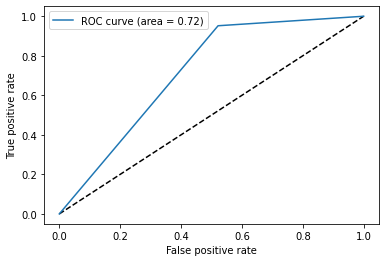

In [213]:
fpr, tpr, thresholds = roc_curve(Y_test,y_pred)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)'% roc_auc_score(Y_test,y_pred))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')

**----- Use One hot Encoder as encoding technique on feature , predict using the below algorithms ----**



3.**Using Logistic Regression - Perform the parameter tuning and list your best performance metrics on -**

**Precision ,Recall & F1 Score ,AUROC**

In [215]:
df_ohe = df.copy()
df_ohe

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,141.866782,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,2900,0.0,71.000000,360.0,1.0,Rural,Y
610,Male,Yes,3+,Graduate,No,4106,0.0,40.000000,180.0,1.0,Rural,Y
611,Male,Yes,1,Graduate,No,8072,240.0,253.000000,360.0,1.0,Urban,Y
612,Male,Yes,2,Graduate,No,7583,0.0,187.000000,360.0,1.0,Urban,Y


In [217]:
for i in categorical_col :
   df_ohe = pd.get_dummies(df_ohe, columns=[i], prefix=('ohe'+str(i)) )
df_ohe.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,oheSelf_Employed_No,oheSelf_Employed_Yes,oheGender_Female,oheGender_Male,oheMarried_No,oheMarried_Yes,oheLoan_Amount_Term_12.0,oheLoan_Amount_Term_36.0,oheLoan_Amount_Term_60.0,oheLoan_Amount_Term_84.0,oheLoan_Amount_Term_120.0,oheLoan_Amount_Term_180.0,oheLoan_Amount_Term_240.0,oheLoan_Amount_Term_300.0,oheLoan_Amount_Term_360.0,oheLoan_Amount_Term_480.0,oheEducation_Graduate,oheEducation_Not Graduate,oheProperty_Area_Rural,oheProperty_Area_Semiurban,oheProperty_Area_Urban,oheLoan_Status_N,oheLoan_Status_Y,oheCredit_History_0.0,oheCredit_History_1.0,oheDependents_0,oheDependents_1,oheDependents_2,oheDependents_3+
0,5849,0.0,141.866782,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,1,0,0,0
1,4583,1508.0,128.000000,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,1,0,1,0,0
2,3000,0.0,66.000000,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,1,0,0,0
3,2583,2358.0,120.000000,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,1,0,0,0
4,6000,0.0,141.000000,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,1,0,0,0


In [218]:
df_ohe.shape

(600, 32)

In [235]:
df_target_ohe = pd.get_dummies(df, columns=['Loan_Status'],prefix=['Loan_Status'])
df_target_ohe

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status_N,Loan_Status_Y
0,Male,No,0,Graduate,No,5849,0.0,141.866782,360.0,1.0,Urban,0,1
1,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,1,0
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,0,1
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,0,1
4,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,2900,0.0,71.000000,360.0,1.0,Rural,0,1
610,Male,Yes,3+,Graduate,No,4106,0.0,40.000000,180.0,1.0,Rural,0,1
611,Male,Yes,1,Graduate,No,8072,240.0,253.000000,360.0,1.0,Urban,0,1
612,Male,Yes,2,Graduate,No,7583,0.0,187.000000,360.0,1.0,Urban,0,1


In [245]:
full_coulmns = []
for i in df.columns:
  full_coulmns.append(i)

full_coulmns.pop(-1)

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History',
 'Property_Area']

In [250]:
df_ohe

,ApplicantIncome,CoapplicantIncome,LoanAmount,oheSelf_Employed_No,oheSelf_Employed_Yes,oheGender_Female,oheGender_Male,oheMarried_No,oheMarried_Yes,oheLoan_Amount_Term_12.0,oheLoan_Amount_Term_36.0,oheLoan_Amount_Term_60.0,oheLoan_Amount_Term_84.0,oheLoan_Amount_Term_120.0,oheLoan_Amount_Term_180.0,oheLoan_Amount_Term_240.0,oheLoan_Amount_Term_300.0,oheLoan_Amount_Term_360.0,oheLoan_Amount_Term_480.0,oheEducation_Graduate,oheEducation_Not Graduate,oheProperty_Area_Rural,oheProperty_Area_Semiurban,oheProperty_Area_Urban,oheLoan_Status_N,oheLoan_Status_Y,oheCredit_History_0.0,oheCredit_History_1.0,oheDependents_0,oheDependents_1,oheDependents_2,oheDependents_3+
0,5849,0.0,141.866782,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,1,0,0,0
1,4583,1508.0,128.000000,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,1,0,1,0,0
2,3000,0.0,66.000000,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,1,0,0,0
3,2583,2358.0,120.000000,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,1,0,0,0
4,6000,0.0,141.000000,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,2900,0.0,71.000000,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,1,1,0,0,0
610,4106,0.0,40.000000,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1
611,8072,240.0,253.000000,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,0
612,7583,0.0,187.000000,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,1,0


In [317]:
df_ohe.shape      #size of ohe dataframe

(600, 32)

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(df_ohe, df_target_le, test_size=0.25, random_state=40, stratify=df_target_le)

In [256]:
#test data size - 20% of dataset
print("Train Feature set:\t"+str(len(X_train)))
print("Train Label Feature set:\t"+str(len(Y_train)))
print("Test Feature set:\t"+str(len(X_test)))
print("Test label set:\t"+str(len(Y_test)))

Train Feature set:	450
Train Label Feature set:	450
Test Feature set:	150
Test label set:	150


In [290]:
clf_dt =LogisticRegression(random_state=40,max_iter=7600)
clf_dt.fit(X_train, np.ravel(Y_train,order='C'))
print(clf_dt)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=7600,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=40, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [0]:
y_pred=clf_dt.predict(X_test)

In [295]:
confusion_matrix(Y_test,y_pred)

array([[ 46,   0],
       [  0, 104]])

False positive = 0 & False Negative = 0 
hence model is perfect

In [298]:
print("Accuracy of Dtree Model:")
print(accuracy_score(Y_test, y_pred))
print("Precision of DTree Model:")
print (precision_score(Y_test, y_pred))
print ("Recall of DTree Model:" )
print( recall_score(Y_test, y_pred))
print ("F1 Score of DTree Model:")
print (f1_score(Y_test, y_pred))

Accuracy of Dtree Model:
1.0
Precision of DTree Model:
1.0
Recall of DTree Model:
1.0
F1 Score of DTree Model:
1.0


In [299]:
roc_auc_score(Y_test,y_pred)

1.0

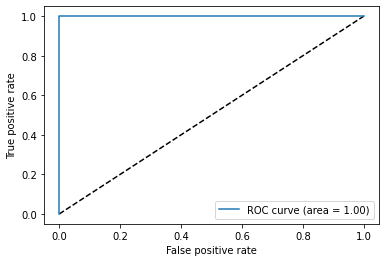

In [300]:
fpr, tpr, thresholds = roc_curve(Y_test,y_pred)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)'% roc_auc_score(Y_test,y_pred))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')

**4.Using RandomForest Classifier - Perform the parameter tuning and list your best performance metrics on -**

**Precision ,Recall & F1 Score ,AUROC**

In [0]:
clf_RF_ohe = RandomForestClassifier()

In [307]:
clf_RF_ohe.fit(X_train,Y_train)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [308]:
clf_RF_ohe.predict(X_test)

array([0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [309]:
#Using Randomforestclassifier without Gridsearch
print("----Parameter tuning without GridSearch-----")
print("Confusion Matrix")
print(confusion_matrix(Y_test,y_pred))
print("Accuracy of Dtree Model:")
print(accuracy_score(Y_test, y_pred))
print("Precision of DTree Model:")
print (precision_score(Y_test, y_pred))
print ("Recall of DTree Model:" )
print( recall_score(Y_test, y_pred))
print ("F1 Score of DTree Model:")
print (f1_score(Y_test, y_pred))

----Parameter tuning without GridSearch-----
Confusion Matrix
[[ 46   0]
 [  0 104]]
Accuracy of Dtree Model:
1.0
Precision of DTree Model:
1.0
Recall of DTree Model:
1.0
F1 Score of DTree Model:
1.0


In [310]:
roc_auc_score(Y_test,y_pred)

1.0

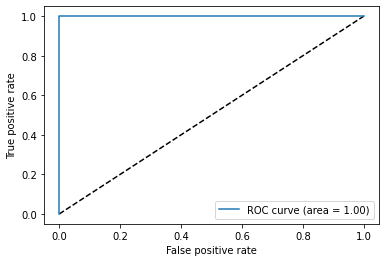

In [311]:
fpr, tpr, thresholds = roc_curve(Y_test,y_pred)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)'% roc_auc_score(Y_test,y_pred))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')

**Which approach between Label Encoding & One Hot Encoding gave better results in case of both the algorithms used ?**

As we can see AUROC curves, which actually tells us that how much our model is able to predict positive class and Negative class(Classes 1 & 0 in this case) it is clear In One Hot Encoding ROC curve for the the algorithms is 1 which represent perfect model but on other hand In Label Encoding ROC curve for both the algorithms(for LogisticRegression- 0.64 & for RandomForest - 0.72)which is not good comparable to One Hand Encoder approach